# Homework 4: Neural Networks

Complete the following questions and resubmit this entire notebook to canvas.
- For questions that ask you to derive or find a quantity use a __text cell__ to show your calculations.
 - Use markdown to write math expressions (as was done to create these problems) and make sure to show your work.
 - It doesnt have to be perfect looking but it needs to be readible.
 - You may also submit a legible picture of your derivation
- For questions that ask you compute something or write code use a __code cell__ to write your code.
 - You can create additional code cells as needed.
 - Just make sure your code is commented, the functions are named appropriately, and its easy to see your final answer.
- The total points on this homework is 120. Out of these 5 points are reserved for clarity of presentation,
punctuation and commenting with respect to the code.

__SUBMISSION__

When you submit you will submit a pdf file __and__ the notebook file. The TA will use the pdf file to grade more quickly. The notebook file is there to confirm your work.

To generate a pdf file
1. Click File
2. Click print
3. Set the destinationas "save as pdf"
4. Hit print


Title the pdf file `LASTNAME-FIRSTNAME-HW4.pdf`
Title your notebook file as `LASTNAME-FIRSTNAME-HW4.ipynb`

Submit both files.




Additional Notes: You may try the following methods if you have any trouble for printing

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [27]:
#!pip install nbconvert
#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!jupyter nbconvert --to pdf /content/drive/MyDrive/STAT421_2025Spring/STAT421_25Spring_Homework/Homework4/hw4.ipynb

In [ ]:
# Alternatively if you want to do it on your own laptop
# 1. Download hw4.ipynb to your laptop
# 2. Make sure you have installed Jupyter Notebook or Jupyter Lab. If not,
#    pip install jupyterlab
# 3. Run the code below on your labtop
#    jupyter nbconvert --to pdf hw4.ipynb

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize

from sklearn import metrics
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings('ignore')

# Question 1 - plotting (10 points)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes (3 channels), with 6000 images per class. There are 50000 training images and 10000 test images. https://www.cs.toronto.edu/~kriz/cifar.html

As a machine learner we test out new algorithms by __benchmarking__ them on standard datasets. CIFAR10 was one of the most commonly used benchmarking datasets for image classifiers before being superceded by much larger and more comprehensive datasets.

Lets benchmark some of the algorithms we have learned on this dataset.

Use the following code to download the data. If you are on google colab you will not need to install any new packages and you can just run the code. If you are not on google colab then install the following packages with

`pip3 install torch torchvision torchaudio`

and then run the code.

In [3]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170M/170M [00:04<00:00, 37.0MB/s] 


Extracting data/cifar-10-python.tar.gz to data


In [5]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
# Train on the first 20000 images
# Test on the last 10000 images

from torch.utils.data import Subset
train_data = Subset(training_data, np.arange(0, 20000))
test_data = Subset(training_data, np.arange(40000, 50000))

## part 1 - EDA

First lets see what were working with. Create a 10x10 array of plots, where each row is a class with 10 example images from that class. For example, row 1 has 10 pictures of airplanes, row 2 has 10 pictures of automobiles, etc. Make sure to include the class name for each row.

Basically just recreate the figure from https://www.cs.toronto.edu/~kriz/cifar.html


In [8]:
# Class labels
class_names = training_data.classes

In [9]:
# Collect 10 examples per class
samples = {i: [] for i in range(10)}
for img, label in training_data:
    if len(samples[label]) < 10:
        samples[label].append(img)
    if all(len(v) == 10 for v in samples.values()):
        break

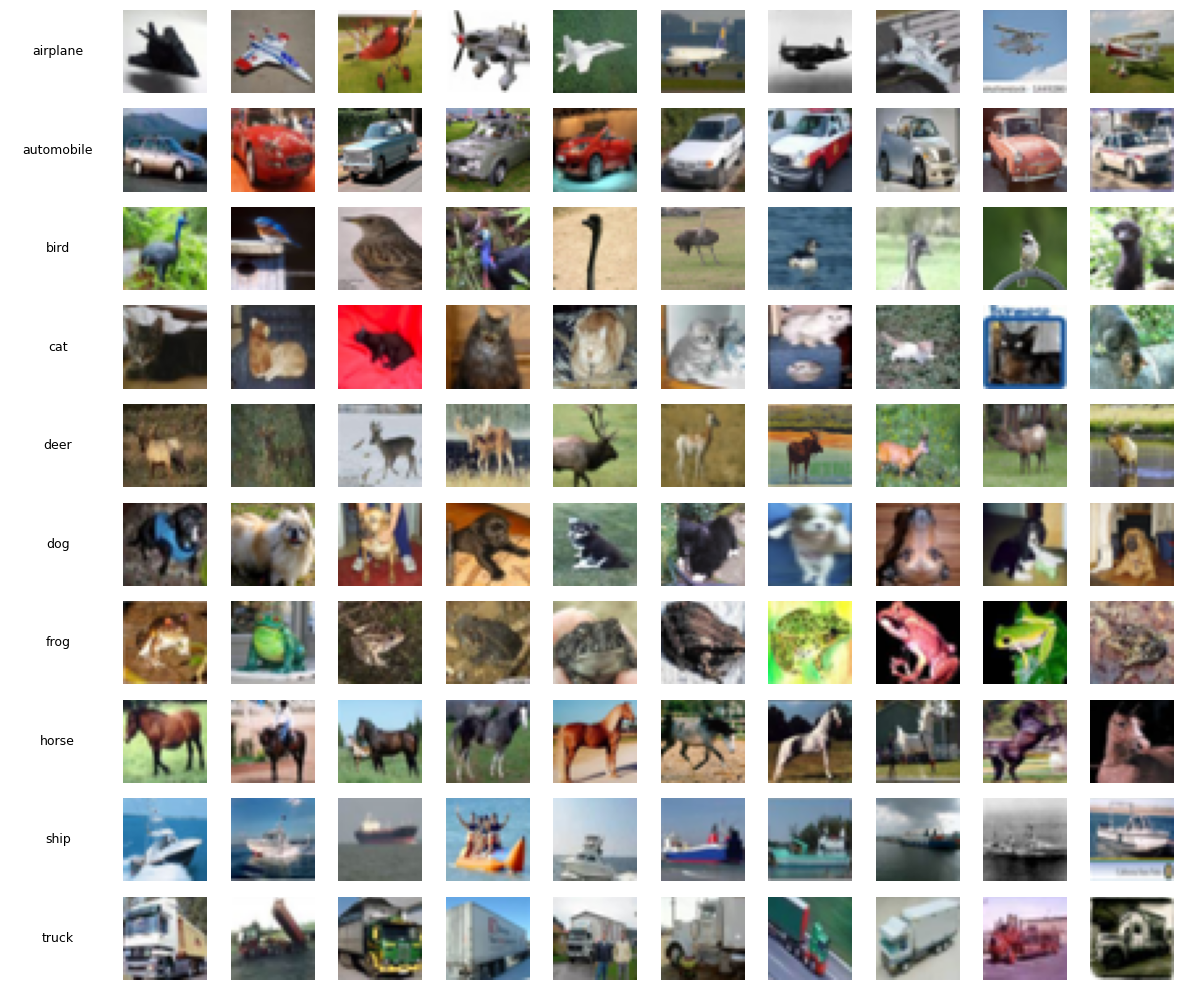

In [114]:
# plot goes here
fig, axs = plt.subplots(10, 11, figsize=(12, 10))

for row in range(10):
    axs[row, 0].text(0.5, 0.5, class_names[row], fontsize=9,
                     ha='center', va='center', rotation=0)
    axs[row, 0].axis('off')  # hide grid for label cell

    for col in range(10):
        axs[row, col + 1].imshow(samples[row][col].permute(1, 2, 0))
        axs[row, col + 1].axis('off')

plt.tight_layout()
plt.show()

# Question 2 - MLPs (45 points)

Our first task is to fit a multilayer perceptron model to CIFAR10. We will construct one model "by hand" and one using all of the tools from pytorch. None of these models are expected to perform super well on image data but you will still need to achieve a relatively low out of sample error rate.

## part 1 - Transform the data (5 points)

First, we need to transform the data so an MLP can use it. Right now your data is stored as 3D tensors (N, C, H, W) so you need to convert these into long vectors (N, C x H x W). Here N is the number of observations, C is the channel depth, H is the height, and W is the width. This means you will need to _flatten_ the 3D image into a vector. Additionally, lets _normalize_ each image so that each channel has a mean pixel value of 0 and standard deviation of 1 to remove spurious pixel variability. You may want to perform this operation before flattening. After flattening subtract off the overall image mean and divide by the overall image standard deviation. While youre at it, go ahead and construct your trainloader and testloader too. Use a batch size < 150.

To summarize
1. _Normalize_ and _flatten_ the image data into vectors for use in an MLP
2. Further standardize images by subtracting off the overall (across all channels), per image, pixel mean and dividing by the overall standard deviation
2. Encode class labels with one hot encoding for use in a Cross Entropy loss
3. Construct a train loader and a test loader (Using `DataLoader()`). Make sure shuffling is on for train (shuffle=True) and off for test (shuffle=False).


_hint: maybe pytorch has some helpful functions_

In [11]:
# Numpy for algorithms using sklearn
train_images = np.zeros((10 * 2000, 3*32*32))
train_labels = np.zeros((10 * 2000, 1))

for i in trange(len(train_data)):
  img, label = train_data[i]
  img = Normalize(0, 1)(img)
  img = (img - torch.mean(img))/torch.std(img)
  img = img.flatten()

  train_images[i] = img
  train_labels[i] = label

test_images = np.zeros((10 * 1000, 3*32*32))
test_labels = np.zeros((10 * 1000, 1))

for i in trange(len(test_data)):
  img, label = test_data[i]
  img = Normalize(0, 1)(img)
  img = (img - torch.mean(img))/torch.std(img)
  img = img.flatten()

  test_images[i] = img
  test_labels[i] = label

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [12]:
train_images = torch.tensor(train_images).float()
test_images = torch.tensor(test_images).float()

In [18]:
# Initialize containers
train_images = np.zeros((10 * 2000, 3 * 32 * 32))
train_labels = np.zeros((10 * 2000, 1))

test_images = np.zeros((10 * 1000, 3 * 32 * 32))
test_labels = np.zeros((10 * 1000, 1))

# Normalize and flatten training data
for i in trange(len(train_images)):
    img, label = train_data[i]
    img = Normalize(0, 1)(img)  # Normalize to [0,1]
    img = (img - torch.mean(img)) / torch.std(img)  # Standardize
    img = img.flatten()  # Flatten to 1D vector
    train_images[i] = img.numpy()
    train_labels[i] = label

# Normalize and flatten testing data
for i in trange(len(test_images)):
    img, label = test_data[i]
    img = Normalize(0, 1)(img)
    img = (img - torch.mean(img)) / torch.std(img)
    img = img.flatten()
    test_images[i] = img.numpy()
    test_labels[i] = label


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
# Convert to tensors
train_images = torch.tensor(train_images).float()
test_images = torch.tensor(test_images).float()
train_labels = torch.tensor(train_labels).long()
test_labels = torch.tensor(test_labels).long()

In [20]:
train_images[0]

tensor([-0.8550, -1.1628, -1.0282,  ...,  0.7032, -0.3741, -0.6050])

In [21]:
test_images[0]

tensor([1.2457, 1.2050, 1.2186,  ..., 0.1330, 0.9200, 1.1507])

In [29]:
## encode the labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(train_labels)

## dont forget to convert to tensors (check float vs double)
train_labels_encoded = torch.tensor(enc.transform(train_labels).toarray()).float()
test_labels_encoded = torch.tensor(enc.transform(test_labels.numpy()).toarray()).float()


In [30]:
# define your data objects and data loaders (check the docs or examples in the class)
batch_size = 128

In [32]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_images, train_labels_encoded)
test_dataset = TensorDataset(test_images, test_labels_encoded)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Confirm shapes
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels_encoded.shape}")

Train images shape: torch.Size([20000, 3072])
Train labels shape: torch.Size([20000, 10])


## part 2 - MLPs by hand-ish (20 points)

Now that we have our data in order lets build our first neural network. To ensure we understand what an MLP does we will build this one without `nn.Linear()` and without using advanced optimization techniques like `optim.adam`. You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples).

Because there are an infinite number of ways to specify a neural network, I'll include some minimal requirements here.

Architecture requirements:
  1. Apply weights with `@` or `torch.matmul()` (no `nn.Linear()`!)
  2. Include a bias term in each layer
  3. Use at least 3 layers (_hint: consider a width > 50 and going deeper_)
  4. Use ReLU activation functions (except the last layer)
  4. Initialize your weights randomly around 0 (_hint: use a small variance_)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Update your weights and biases via gradient descent without using an optimizer function (_hint: use a very low learning rate like `1e-4`_)
  3. Train until your test cross entropy loss is $< 0.2$. (< 2 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace
  5. You may use a GPU


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.?



In [33]:
## if you like GPUs
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [37]:
import torch.nn.functional as F

# homegrown
class neural_network(nn.Module):
    def __init__(self, x, width, device):
      super(neural_network, self).__init__()
      self.W1 = nn.Parameter(torch.randn(input_dim, width, device=device) * 0.01)
      self.b1 = nn.Parameter(torch.zeros(width, device=device))
      self.W2 = nn.Parameter(torch.randn(width, 10, device=device) * 0.01)
      self.b2 = nn.Parameter(torch.zeros(10, device=device))

    def forward(self, x):
        z1 = x @ self.W1 + self.b1  # Linear layer 1
        a1 = torch.relu(z1)         # ReLU activation
        z2 = a1 @ self.W2 + self.b2 # Linear layer 2
        return F.softmax(z2, dim=1) # Output probabilities

### the loss you may use for this task.
def cross_entropy(model, x, y):
  p = model(x)
  return -torch.mean(torch.sum(y * torch.log(p + 1e-9), dim=1))  # Add small value to avoid log(0)


In [ ]:
# Hyperparameters
input_dim = 3072  # 3x32x32
hidden_dim = 256
epochs = 10
lr = 0.01

In [40]:
# Model initialization
model = neural_network(input_dim, hidden_dim, device).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        xb, yb = xb.to(device), yb.to(device)
        loss = cross_entropy(model, xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test loss (no gradient)
    model.eval()
    with torch.no_grad():
        running_test_loss = 0
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            test_loss = cross_entropy(model, xb, yb)
            running_test_loss += test_loss.item()
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.1114, Test Loss: 1.9662


Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2, Train Loss: 1.8763, Test Loss: 1.8386


Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3, Train Loss: 1.7716, Test Loss: 1.7699


Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4, Train Loss: 1.7025, Test Loss: 1.7224


Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5, Train Loss: 1.6495, Test Loss: 1.6844


Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6, Train Loss: 1.6053, Test Loss: 1.6558


Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7, Train Loss: 1.5667, Test Loss: 1.6353


Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8, Train Loss: 1.5336, Test Loss: 1.6127


Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9, Train Loss: 1.5019, Test Loss: 1.6020


Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10, Train Loss: 1.4742, Test Loss: 1.5790


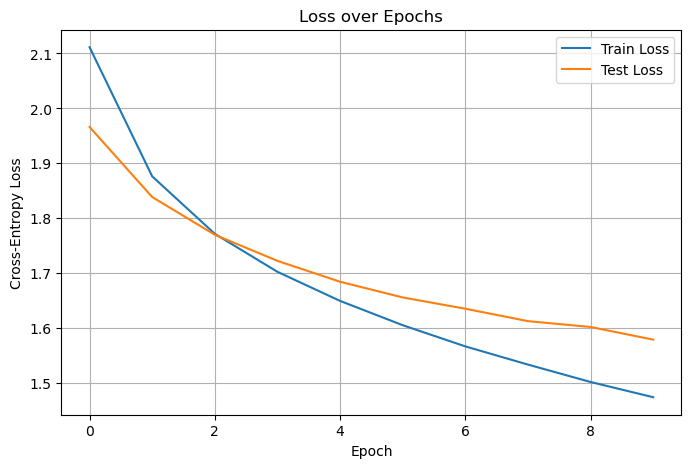

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
from sklearn.metrics import classification_report

# Gather predictions
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        predicted = torch.argmax(preds, dim=1).cpu().numpy()
        target = torch.argmax(yb, dim=1).cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(target)

# Generate classification report
class_names = training_data.classes
report = classification_report(all_targets, all_preds, target_names=class_names, digits=3)
print(report)


              precision    recall  f1-score   support

    airplane      0.521     0.454     0.485      1014
  automobile      0.476     0.568     0.518      1014
        bird      0.324     0.313     0.318       952
         cat      0.333     0.292     0.311      1016
        deer      0.397     0.358     0.376       997
         dog      0.359     0.339     0.348      1025
        frog      0.485     0.459     0.472       980
       horse      0.477     0.521     0.498       977
        ship      0.526     0.667     0.588      1003
       truck      0.501     0.471     0.485      1022

    accuracy                          0.444     10000
   macro avg      0.440     0.444     0.440     10000
weighted avg      0.440     0.444     0.440     10000




Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.?

From the classification report, the "cat" class was the hardest to get right. It had the lowest precision and recall, meaning the model often confused it with similar animals like dogs. This makes sense since those classes can look alike in small images.

## part 3 - MLPs redux (20 points)

Now that we have convinced ourselves that neural networks can be created and trained "by hand", lets use some conveniences from pytorch to see if we can do better. This is essentially part 2 repeated using `nn.Linear()` and `torch.adam` to ease model construction and training.  You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples).

Because there are an infinite number of ways to specify a neural network, I'll include some minimal requirements here again.


Model requirements:
  1. Include a bias term in each layer
  2. Use at least 3 layers
  3. Use ReLU activation functions (except the last layer)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Use the `adam` optimizer () (_hint: use a very low learning rate like `1e-4`_)
  3. Train until your test cross entropy loss is $< 0.2$ (< 2 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

In [44]:
# regular
class neural_network(nn.Module):
    def __init__(self, x, width, device):
      super(neural_network, self).__init__()
      self.model = nn.Sequential(
      nn.Linear(input_dim, width),
      nn.ReLU(),
      nn.Linear(width, width),
      nn.ReLU(),
      nn.Linear(width, 10)
  )

    def forward(self, x):
      return self.model(x)

In [45]:
# Hyperparameters
input_dim = 3072
hidden_dim = 256
epochs = 20
batch_size = 128
lr = 1e-4

In [46]:
# Prepare datasets (use class indices instead of one-hot labels)
train_labels_cls = torch.tensor(train_labels.numpy().flatten(), dtype=torch.long)
test_labels_cls = torch.tensor(test_labels.numpy().flatten(), dtype=torch.long)

train_dataset = TensorDataset(train_images, train_labels_cls)
test_dataset = TensorDataset(test_images, test_labels_cls)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
from torch.optim import Adam

# Model, loss, and optimizer (on CPU)
model = neural_network(input_dim, hidden_dim, device)
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [50]:
# Train/test loss tracking
train_losses = []
test_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_train_loss = 0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    running_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            running_test_loss += loss.item()
    test_losses.append(running_test_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")


Epoch 1, Train Loss: 0.6748, Test Loss: 1.6021
Epoch 2, Train Loss: 0.6389, Test Loss: 1.6275
Epoch 3, Train Loss: 0.5969, Test Loss: 1.6628
Epoch 4, Train Loss: 0.5657, Test Loss: 1.7023
Epoch 5, Train Loss: 0.5321, Test Loss: 1.7173
Epoch 6, Train Loss: 0.4964, Test Loss: 1.7373
Epoch 7, Train Loss: 0.4639, Test Loss: 1.7736
Epoch 8, Train Loss: 0.4324, Test Loss: 1.8070
Epoch 9, Train Loss: 0.4028, Test Loss: 1.8371
Epoch 10, Train Loss: 0.3767, Test Loss: 1.8656
Epoch 11, Train Loss: 0.3503, Test Loss: 1.9135
Epoch 12, Train Loss: 0.3268, Test Loss: 1.9451
Epoch 13, Train Loss: 0.3021, Test Loss: 1.9819
Epoch 14, Train Loss: 0.2772, Test Loss: 2.0234
Epoch 15, Train Loss: 0.2553, Test Loss: 2.0740
Epoch 16, Train Loss: 0.2355, Test Loss: 2.1089
Epoch 17, Train Loss: 0.2187, Test Loss: 2.1558
Epoch 18, Train Loss: 0.1979, Test Loss: 2.2055
Epoch 19, Train Loss: 0.1828, Test Loss: 2.2564
Epoch 20, Train Loss: 0.1703, Test Loss: 2.2928


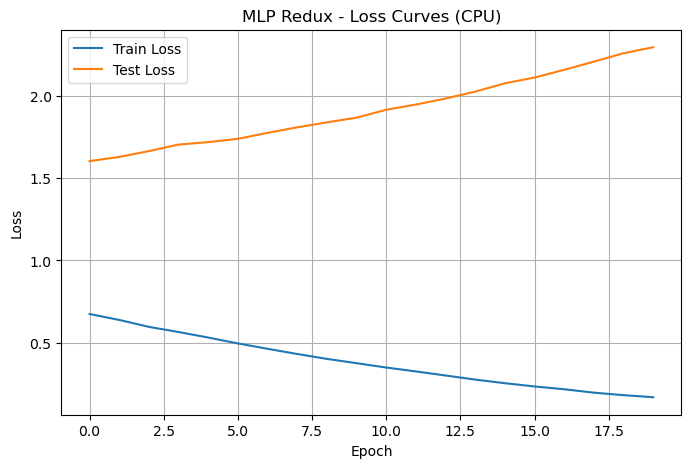

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("MLP Redux - Loss Curves (CPU)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
# Predictions and targets
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        predicted = torch.argmax(preds, dim=1).numpy()
        all_preds.extend(predicted)
        all_targets.extend(yb.numpy())

# Print report
print(classification_report(all_targets, all_preds, target_names=class_names, digits=3))


              precision    recall  f1-score   support

    airplane      0.543     0.490     0.515      1014
  automobile      0.578     0.541     0.559      1014
        bird      0.334     0.379     0.355       952
         cat      0.310     0.323     0.316      1016
        deer      0.427     0.357     0.389       997
         dog      0.361     0.307     0.332      1025
        frog      0.481     0.514     0.497       980
       horse      0.531     0.548     0.539       977
        ship      0.587     0.657     0.620      1003
       truck      0.494     0.536     0.514      1022

    accuracy                          0.465     10000
   macro avg      0.464     0.465     0.464     10000
weighted avg      0.465     0.465     0.464     10000



Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

The model shows overfitting as the train loss drops, but test loss increases after a few epochs. Test accuracy improved slightly from 44.4% to 46.5%. The "cat" class is still the hardest to classify, with the lowest F1-score (0.316) due to low precision and recall.

# Question 3 - Convnets (60 points)

Our next task is to fit a convolutional neural network (CNN) to CIFAR10. Again, we will construct one model "by hand" and one using all of the tools from pytorch. Because convolutions utilize spatial information, they tend to perform much better than MLPs. These models should work considerably better the MLP models above.

## part 1 - Transform the data (5 points)

In Question 2, we had to transform our data into vector form so that an MLP could use it. This time we want to keep the tensor form since a CNN expects tensor inputs, i.e. inputs shaped like (N, C, H, W). Perform the exact same data standardization as in Question 1, part 1, except __do not__ flatten the images. Make sure to create train loaders and test loaders again and do not shuffle the test data.

In [57]:
# Numpy for algorithms using sklearn (ur welcome)
train_images = np.zeros((10 * 2000, 3, 32, 32))
train_labels = np.zeros((10 * 2000, 1))

test_images = np.zeros((10 * 1000, 3, 32, 32))
test_labels = np.zeros((10 * 1000, 1))

# Standardization function
def standardize(img):
    img = Normalize(0, 1)(img)
    return (img - torch.mean(img)) / torch.std(img)

for i in trange(len(train_data)):
    img, label = train_data[i]
    img = standardize(img)
    train_images[i] = img.numpy()
    train_labels[i] = label

for i in trange(len(test_data)):
    img, label = test_data[i]
    img = standardize(img)
    test_images[i] = img.numpy()
    test_labels[i] = label

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [58]:
# Convert to tensors
train_images = torch.tensor(train_images).float()
test_images = torch.tensor(test_images).float()
train_labels = torch.tensor(train_labels).long().squeeze()
test_labels = torch.tensor(test_labels).long().squeeze()

In [60]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse_output=False)

# Reshape labels for one-hot encoding
train_labels_onehot = torch.tensor(enc.fit_transform(train_labels.reshape(-1, 1))).float()
test_labels_onehot = torch.tensor(enc.transform(test_labels.reshape(-1, 1))).float()

In [61]:
# Dataloader for algorithms using pytorch
batch_size = 128

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
# Confirm shape
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

Train images shape: torch.Size([20000, 3, 32, 32])
Train labels shape: torch.Size([20000])


## part 2 - Convnets by hand-ish (20 points)

Now that we have our data in order for lets build our first CNN. To ensure we understand what an CNN does we will build this one without `nn.Conv2d()` and without using advanced optimization techniques like `optim.adam`. You may use classes to define your model and other torch functions like `nn.ReLU()` (See the neural network lectures for examples). You also may use `nn.functional.conv2d()` to apply conv filters and `nn.MaxPool2d()` or `nn.AvgPool2d()` for pooling.

Architecture requirements:
  1. Apply filter weights with `nn.functional.conv2d()` in your forward function
  2. Include a bias term in each layer
  3. Use at least 3 layers
  4. Use ReLU activation functions (except the last layer)
  4. Initialize your filter weights randomly around 0 (_hint: use a small variance_)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Update your weights and biases via gradient descent without using an optimizer function
  3. Train until test cross entropy < 0.15 (< 1.5 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace

Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.

In [92]:
import torch.nn.init as init

class convnet(nn.Module):
    def __init__(self):
      super(convnet, self).__init__()
      # Convolutional filter weights and biases (He initialization)
      self.W1 = nn.Parameter(torch.empty(16, 3, 3, 3))
      init.kaiming_uniform_(self.W1, a=0)
      self.b1 = nn.Parameter(torch.zeros(16))

      self.W2 = nn.Parameter(torch.empty(32, 16, 3, 3))
      init.kaiming_uniform_(self.W2, a=0)
      self.b2 = nn.Parameter(torch.zeros(32))

      self.W3 = nn.Parameter(torch.empty(64, 32, 3, 3))
      init.kaiming_uniform_(self.W3, a=0)
      self.b3 = nn.Parameter(torch.zeros(64))

      # Dummy input to compute final flattened dimension
      dummy = torch.zeros(1, 3, 32, 32)
      x = F.max_pool2d(F.relu(F.conv2d(dummy, self.W1, self.b1, padding=1)), 2)
      x = F.max_pool2d(F.relu(F.conv2d(x, self.W2, self.b2, padding=1)), 2)
      x = F.max_pool2d(F.relu(F.conv2d(x, self.W3, self.b3, padding=1)), 2)
      flat_dim = x.view(1, -1).shape[1]

      # Final fully connected layer (raw logits)
      self.fc = nn.Linear(flat_dim, 10)

    def forward(self, x):
      x = F.conv2d(x, self.W1, self.b1, padding=1)
      x = F.relu(x)
      x = F.max_pool2d(x, 2)

      x = F.conv2d(x, self.W2, self.b2, padding=1)
      x = F.relu(x)
      x = F.max_pool2d(x, 2)

      x = F.conv2d(x, self.W3, self.b3, padding=1)
      x = F.relu(x)
      x = F.max_pool2d(x, 2)

      x = x.view(x.size(0), -1)
      return self.fc(x)  # Return raw logits

In [93]:
model = convnet()
loss_fn = nn.CrossEntropyLoss()

epochs = 20
lr = 0.005
train_losses = []
test_losses = []

In [94]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()

        # Manually update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
                param.grad.zero_()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Test evaluation
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            test_loss = loss_fn(preds, yb)
            total_test_loss += test_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch 1, Train Loss: 1.9426, Test Loss: 1.8530
Epoch 2, Train Loss: 1.6957, Test Loss: 1.7499
Epoch 3, Train Loss: 1.5821, Test Loss: 1.6193
Epoch 4, Train Loss: 1.4977, Test Loss: 1.6901
Epoch 5, Train Loss: 1.4364, Test Loss: 1.5541
Epoch 6, Train Loss: 1.3929, Test Loss: 1.6009
Epoch 7, Train Loss: 1.3486, Test Loss: 1.4532
Epoch 8, Train Loss: 1.3115, Test Loss: 1.3739
Epoch 9, Train Loss: 1.2797, Test Loss: 1.3836
Epoch 10, Train Loss: 1.2497, Test Loss: 1.4596
Epoch 11, Train Loss: 1.2334, Test Loss: 1.3439
Epoch 12, Train Loss: 1.2059, Test Loss: 1.4746
Epoch 13, Train Loss: 1.1866, Test Loss: 1.3801
Epoch 14, Train Loss: 1.1651, Test Loss: 1.4794
Epoch 15, Train Loss: 1.1499, Test Loss: 1.3982
Epoch 16, Train Loss: 1.1324, Test Loss: 1.3704
Epoch 17, Train Loss: 1.1131, Test Loss: 1.2902
Epoch 18, Train Loss: 1.0976, Test Loss: 1.3461
Epoch 19, Train Loss: 1.0809, Test Loss: 1.3472
Epoch 20, Train Loss: 1.0658, Test Loss: 1.3131


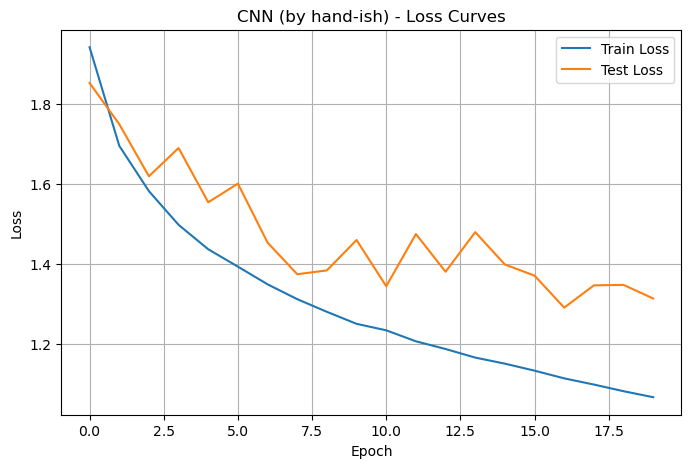

In [95]:
# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("CNN (by hand-ish) - Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [96]:
# Classification report
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        pred_labels = torch.argmax(preds, dim=1)
        all_preds.extend(pred_labels.numpy())
        all_targets.extend(yb.numpy())

print(classification_report(all_targets, all_preds, target_names=class_names, digits=3))

              precision    recall  f1-score   support

    airplane      0.494     0.736     0.591      1014
  automobile      0.549     0.786     0.646      1014
        bird      0.476     0.425     0.449       952
         cat      0.366     0.536     0.435      1016
        deer      0.568     0.410     0.476       997
         dog      0.564     0.377     0.452      1025
        frog      0.720     0.556     0.628       980
       horse      0.905     0.343     0.497       977
        ship      0.711     0.707     0.709      1003
       truck      0.542     0.620     0.579      1022

    accuracy                          0.551     10000
   macro avg      0.590     0.550     0.546     10000
weighted avg      0.588     0.551     0.547     10000



Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc.

The train and test loss curves show steady convergence with some signs of overfitting, but overall learning was effective. Test accuracy reached 55.1%, with strong performance on ship, automobile, and airplane. The hardest class to classify was horse, with a low F1-score of 0.497, mainly due to a very low recall (0.343), meaning many horses were misclassified.

## part 3 - Convnets redux (20 points)


Now that we can write and train a CNN "by hand", lets use all of the convenience of pytorch to train a better one. This time you should construct your model using `nn.Conv2d()` and use a momentum based optimizer like `adam`. I will again include a few baseline requirements for your model and training procedure.

Model requirements:
  1. Include a bias term in each layer
  2. Use at least 3 layers
  3. Use ReLU activation functions (except the last layer)

Loss requirements:
  1. Use an appropriate classification loss (_hint: make sure your model returns probabilities_)

Train requirements:
  1. Use a dataloader with a batch size < 150
  2. Use the `adam` optimizer
  3. Train until test cross entropy < 0.15 (< 1.5 if use `nn.CrossEntropyLoss()`)
  4. Keep a train loss trace and a test loss trace


Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

_Hint: probably you can convert your model to double precision with `cnn = cnn.to(torch.float64)` if you encouter any related error_

In [99]:
class convnet(nn.Module):
    def __init__(self):
      super(convnet, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=True)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=True)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=True)
      self.pool = nn.MaxPool2d(2, 2)
      
      self.flatten_dim = 64 * 4 * 4  # After 3 poolings on 32x32 input
      self.fc = nn.Linear(self.flatten_dim, 10)

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))  # 32 → 16
      x = self.pool(F.relu(self.conv2(x)))  # 16 → 8
      x = self.pool(F.relu(self.conv3(x)))  # 8 → 4
      x = x.view(-1, self.flatten_dim)
      return self.fc(x)  # Raw logits

In [100]:
# Model init
model = convnet()
model = model.to(torch.float32)

# Optimizer and loss
optimizer = Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Training
epochs = 20
train_losses = []
test_losses = []

In [101]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for xb, yb in train_loader:
        xb = xb.float()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Evaluate on test set
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.float()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()
    test_losses.append(total_test_loss / len(test_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch 1, Train Loss: 2.1191, Test Loss: 1.9010
Epoch 2, Train Loss: 1.8019, Test Loss: 1.7555
Epoch 3, Train Loss: 1.6888, Test Loss: 1.6623
Epoch 4, Train Loss: 1.6113, Test Loss: 1.6043
Epoch 5, Train Loss: 1.5516, Test Loss: 1.5550
Epoch 6, Train Loss: 1.5081, Test Loss: 1.5124
Epoch 7, Train Loss: 1.4667, Test Loss: 1.4795
Epoch 8, Train Loss: 1.4365, Test Loss: 1.4502
Epoch 9, Train Loss: 1.4059, Test Loss: 1.4227
Epoch 10, Train Loss: 1.3770, Test Loss: 1.4244
Epoch 11, Train Loss: 1.3571, Test Loss: 1.3827
Epoch 12, Train Loss: 1.3312, Test Loss: 1.3660
Epoch 13, Train Loss: 1.3131, Test Loss: 1.3529
Epoch 14, Train Loss: 1.2948, Test Loss: 1.3422
Epoch 15, Train Loss: 1.2795, Test Loss: 1.3226
Epoch 16, Train Loss: 1.2594, Test Loss: 1.3084
Epoch 17, Train Loss: 1.2443, Test Loss: 1.2992
Epoch 18, Train Loss: 1.2314, Test Loss: 1.2894
Epoch 19, Train Loss: 1.2174, Test Loss: 1.2680
Epoch 20, Train Loss: 1.2014, Test Loss: 1.2691


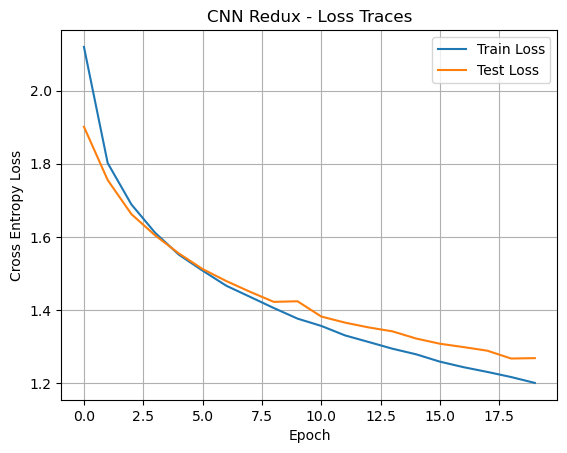

In [102]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("CNN Redux - Loss Traces")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
all_preds, all_targets = [], []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.float()
        preds = model(xb)
        pred_labels = torch.argmax(preds, dim=1)
        all_preds.extend(pred_labels.numpy())
        all_targets.extend(yb.numpy())

print(classification_report(all_targets, all_preds, target_names=class_names, digits=3))

              precision    recall  f1-score   support

    airplane      0.618     0.608     0.613      1014
  automobile      0.687     0.589     0.634      1014
        bird      0.463     0.439     0.451       952
         cat      0.375     0.545     0.444      1016
        deer      0.483     0.470     0.477       997
         dog      0.594     0.262     0.364      1025
        frog      0.628     0.589     0.608       980
       horse      0.617     0.607     0.612       977
        ship      0.634     0.752     0.688      1003
       truck      0.543     0.669     0.600      1022

    accuracy                          0.553     10000
   macro avg      0.564     0.553     0.549     10000
weighted avg      0.564     0.553     0.549     10000



Plot the train and test loss traces to assess convergence and possible overfitting or underfitting. Report your classification report on the test data. Which class is the hardest to classify based on precision, recall, etc. Compare these results to the ones you got in part 2.

The loss curves show steady learning with little overfitting. Test accuracy improved to 55.3%, slightly better than Part 2. The model did well on ship, horse, and airplane. Dog was the hardest to classify, with the lowest F1-score (0.364) due to low recall.

## part 4 - Additional Invariances (15 points)

Our CNN model can be trained to an impressively high degree of accuracy. However, although its robust to translations of the object in the image, its not robust to other forms of image ``noise''. Here we will consider two kinds of image corruption/noise that are irrelevant to the class of the object: Color inversion and Color jittering. You can see examples of this here under Photometric Transforms.
https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py


We will use a simple data augmentation strategy to encourage our model to be invariant to these two transformations.
1. Random color inversion
2. Random color jittering

You may find the following functions helpful for augmenting your training procedure
1. `torchvision.transforms.invert()`
2. `torchvision.transforms.ColorJitter()`

Demonstrate that your model is invariant to these transformation by comparing the test cross entropy and classification reports against
1. A standard CNN applied to randomly inverted and jittered images (you should have a much lower test loss and higher test F1s)
2. A standard CNN applied to uncorrupted images (you should have a comparable test loss and test F1)

In [104]:
import torchvision.transforms as transforms

# Augmented transform (only for training)
train_transform_aug = transforms.Compose([
    transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)], p=0.5),
    transforms.RandomApply([transforms.RandomInvert(p=1.0)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Standard transform for test (no corruption)
test_transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Corrupted test transform (simulate noise during eval)
test_transform_corrupted = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomInvert(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [105]:
from torchvision.datasets import CIFAR10

# Load datasets with transforms
train_data_aug = CIFAR10(root='data', train=True, download=True, transform=train_transform_aug)
test_data_clean = CIFAR10(root='data', train=False, download=True, transform=test_transform_clean)
test_data_corrupted = CIFAR10(root='data', train=False, download=True, transform=test_transform_corrupted)

from torch.utils.data import DataLoader

batch_size = 128

train_loader_aug = DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)
test_loader_clean = DataLoader(test_data_clean, batch_size=batch_size, shuffle=False)
test_loader_corrupted = DataLoader(test_data_corrupted, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [109]:
import torch.nn as nn
import torch.nn.functional as F

class convnet(nn.Module):
    def __init__(self):
        super(convnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 4 * 4, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32 → 16
        x = self.pool(F.relu(self.conv2(x)))  # 16 → 8
        x = self.pool(F.relu(self.conv3(x)))  # 8 → 4
        x = x.view(x.size(0), -1)
        return self.fc(x)  # raw logits

In [110]:
model_aug = convnet()
optimizer = Adam(model_aug.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

epochs = 15
train_losses_aug = []

for epoch in range(epochs):
    model_aug.train()
    total_loss = 0
    for xb, yb in train_loader_aug:
        xb = xb.float()
        preds = model_aug(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader_aug)
    train_losses_aug.append(avg_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}")


Epoch 1, Train Loss: 2.2090
Epoch 2, Train Loss: 1.9385
Epoch 3, Train Loss: 1.8205
Epoch 4, Train Loss: 1.7440
Epoch 5, Train Loss: 1.6910
Epoch 6, Train Loss: 1.6569
Epoch 7, Train Loss: 1.6202
Epoch 8, Train Loss: 1.5900
Epoch 9, Train Loss: 1.5620
Epoch 10, Train Loss: 1.5372
Epoch 11, Train Loss: 1.5106
Epoch 12, Train Loss: 1.4891
Epoch 13, Train Loss: 1.4644
Epoch 14, Train Loss: 1.4500
Epoch 15, Train Loss: 1.4298


In [113]:
def evaluate_model(model, loader, name=""):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.float()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_loss += loss.item()
            pred_labels = torch.argmax(preds, dim=1)
            all_preds.extend(pred_labels.numpy())
            all_targets.extend(yb.numpy())
    avg_loss = total_loss / len(loader)
    print(f"{name} Test Loss: {avg_loss:.4f}")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=3))

# Evaluate on clean test set
evaluate_model(model_aug, test_loader_clean, "Clean")

# Evaluate on corrupted test set
evaluate_model(model_aug, test_loader_corrupted, "Corrupted")


Clean Test Loss: 1.3820
              precision    recall  f1-score   support

    airplane      0.564     0.537     0.550      1000
  automobile      0.589     0.591     0.590      1000
        bird      0.384     0.438     0.409      1000
         cat      0.367     0.282     0.319      1000
        deer      0.472     0.493     0.482      1000
         dog      0.528     0.366     0.432      1000
        frog      0.605     0.617     0.611      1000
       horse      0.576     0.602     0.588      1000
        ship      0.538     0.677     0.599      1000
       truck      0.496     0.532     0.514      1000

    accuracy                          0.513     10000
   macro avg      0.512     0.513     0.510     10000
weighted avg      0.512     0.513     0.510     10000

Corrupted Test Loss: 1.4553
              precision    recall  f1-score   support

    airplane      0.536     0.465     0.498      1000
  automobile      0.603     0.572     0.587      1000
        bird      0.391   

The model performed well on both clean (51.3%) and corrupted (49.2%) test sets. The small drop shows it learned to handle color noise, making it more robust thanks to the augmentation.